# 13 Prédiction de séries temporelles

Dans ce notebook, nous allons dérouler toute la procédure de prédiction d'une série temporelle avec SARIMA.

## 13.1 Imports

In [ ]:
!pip install pmdarima
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.6 MB/s eta 0:00:00


In [ ]:
import warnings

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from scipy import stats
from itertools import product

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## 13.2 Méthodes

Dans les cellules suivantes nous définissons plusieurs méthodes qui nous serviront à réaliser et analyser une prédiction de série temporelle avec SARIMA.

In [ ]:
def check_stationarization(data, field, seasonal_period=4):
    show_lagplots(data, field)
    if len(data) > 6 * seasonal_period:
        show_adfuller_stats(data, field, seasonal_period)

def show_lagplots(data, originalfield):
    if 'diff_seasonal_diff_{}'.format(field) in data.columns:
        figure, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))
    elif 'seasonal_diff_{}'.format(field) in data.columns:
        figure, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    else:
        figure, (ax0) = plt.subplots(1, 1, figsize=(5, 5))

    figure.tight_layout()

    lag_plot(data[field], ax=ax0)
    ax0.set_title('{} data'.format(field));

    if 'seasonal_diff_{}'.format(field) in data.columns:
        lag_plot(data['seasonal_diff_{}'.format(field)] , ax=ax1)
        ax1.set_title('{} with seasonal differencing'.format(field));

    if 'diff_seasonal_diff_{}'.format(field) in data.columns:
        lag_plot(data['diff_seasonal_diff_{}'.format(field)] , ax=ax2)
        ax2.set_title('{} data with seasonal differencing + 1-step differencing'.format(field));

    plt.show()

def plot_acf_pacf(series, seasonal_period):
    lags_long = 2 * seasonal_period + 20
    lags_short = seasonal_period // 3


    f2, ((ax4, ax5), (ax6, ax7)) = plt.subplots(2, 2, figsize=(15, 5))
    f2.tight_layout()

    plot_acf(series, ax=ax4, lags=lags_long)
    ax4.set_title('ACF plot, long lag period');

    plot_acf(series, ax=ax5, lags=lags_short)
    ax5.set_title('ACF plot, short lag period');

    plot_pacf(series, ax=ax6, lags=lags_long)
    ax6.set_title('PACF plot, long lag period');

    plot_pacf(series, ax=ax7, lags=lags_short)
    ax7.set_title('PACF plot, short lag period');

    plt.show()

def inspect_results(results):
    print(results.summary())
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

def show_adfuller_stats(data, field, seasonal_period=4):
    print('==== Augmented Dickey–Fuller test ================================================================================\n')
    print('---- {} ---------------------------------------------------\n'.format(field))
    adf = adfuller(data[field].dropna(), regression='n', autolag=None, maxlag=4 * seasonal_period)

    print('  statistical value: {}'.format(adf[0]))
    print('    (stationarity achieved if lower than the critical values)\n')
    print('  p-value: {}'.format(adf[1]))
    print('    (stationarity achieved if lower 0.05)\n')
    print('  lags considered for calculation: {}'.format(adf[2]))
    print('  critical values: {}\n\n'.format(adf[4]))
    print('==================================================================================================================')

## 13.3 Chargement du dataset

Chargez le dataset `Quarterly_Earnings_per_Johnson___Johnson_Share_398_57.csv` en ne retenant que les colonnes `time` et `value` :

In [ ]:
# todo
data = pd.read_csv(
    './data/Quarterly_Earnings_per_Johnson___Johnson_Share_398_57.csv',
    usecols=['time', 'value']
)
print(data.shape)

(84, 2)


In [ ]:
data.head(10)

,time,value
0,1960.00,0.71
1,1960.25,0.63
2,1960.50,0.85
3,1960.75,0.44
4,1961.00,0.61
5,1961.25,0.69
6,1961.50,0.92
7,1961.75,0.55
8,1962.00,0.72
9,1962.25,0.77


## 13.4 Visualisation des données

Visualisez cette série :

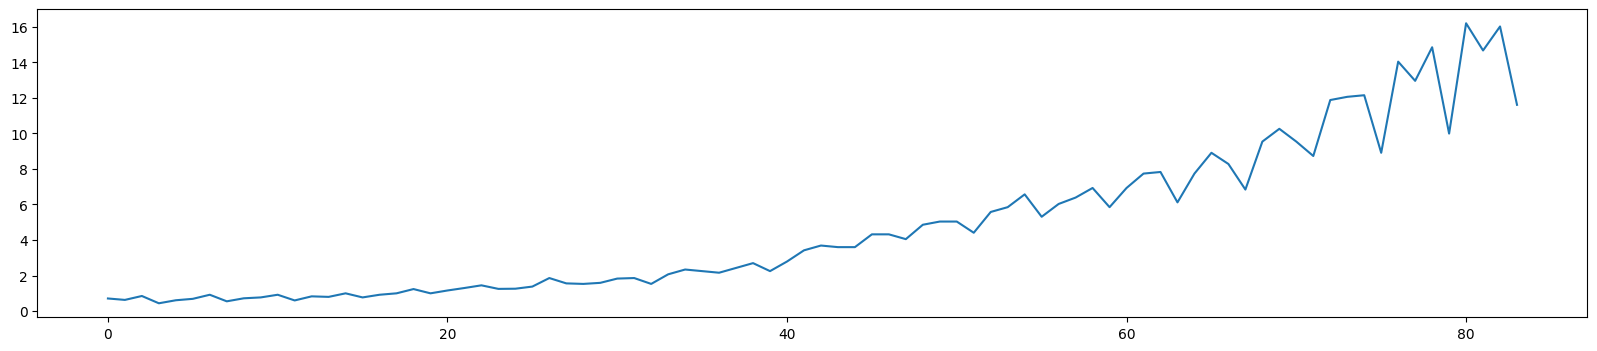

In [ ]:
data.value.plot(figsize=(20, 4))
plt.show()

Ces données sont typiques d'une série où les composantes tendance - saisonnsalité - résidu sont en relation multiplicative.

Pourquoi ?

Car les écarts relatifs sont plus grand pour des temps élevés.

## 13.5 Transformation des données

Pour passer d'un mode multiplicatif à un mode additif, une transformation est nécessaire. Le plus simple est l'application d'un logarithme :

In [ ]:
data['log_value'] = np.log(data.value)
data['recalculate_original'] = np.exp(data.log_value)

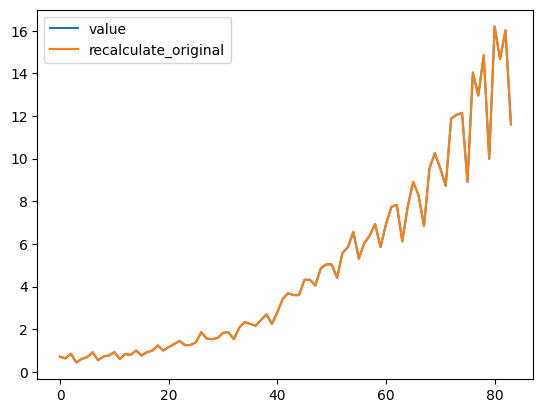

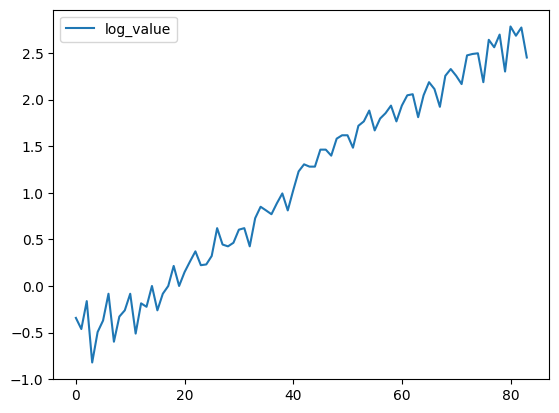

In [ ]:
data.value.plot()
data.recalculate_original.plot()
plt.legend()
plt.show()

data.log_value.plot()
plt.legend()
plt.show()

Une solution paramétrique est la transformée de Box-Cox :

Testez différents paramètres. Pour accentuer la correction, lambda peut être pris < 0...

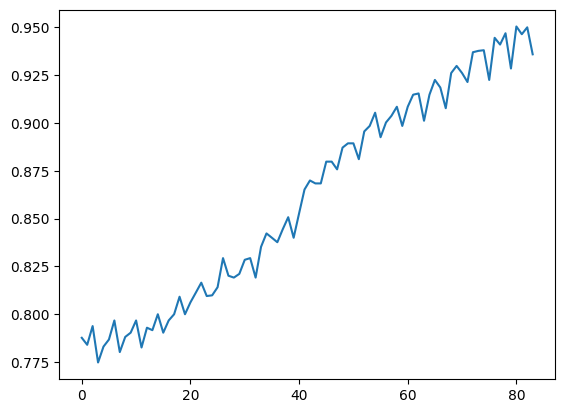

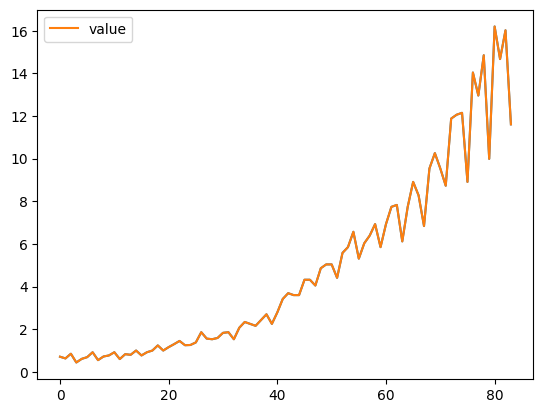

In [ ]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox


lambda_boxcox = -1
constant_boxcox = 4

boxcoxed = boxcox(data.value + constant_boxcox, lambda_boxcox)

data['boxcox_value'] = boxcoxed

pd.Series(boxcoxed).plot()
plt.show()

inv_boxcoxed = inv_boxcox(boxcoxed, lambda_boxcox) - constant_boxcox

pd.Series(inv_boxcoxed).plot()
data.value.plot()
plt.legend()
plt.show()

## 13.6 Décomposition STL

Effectuez une décomposition STL des signaux transformés :

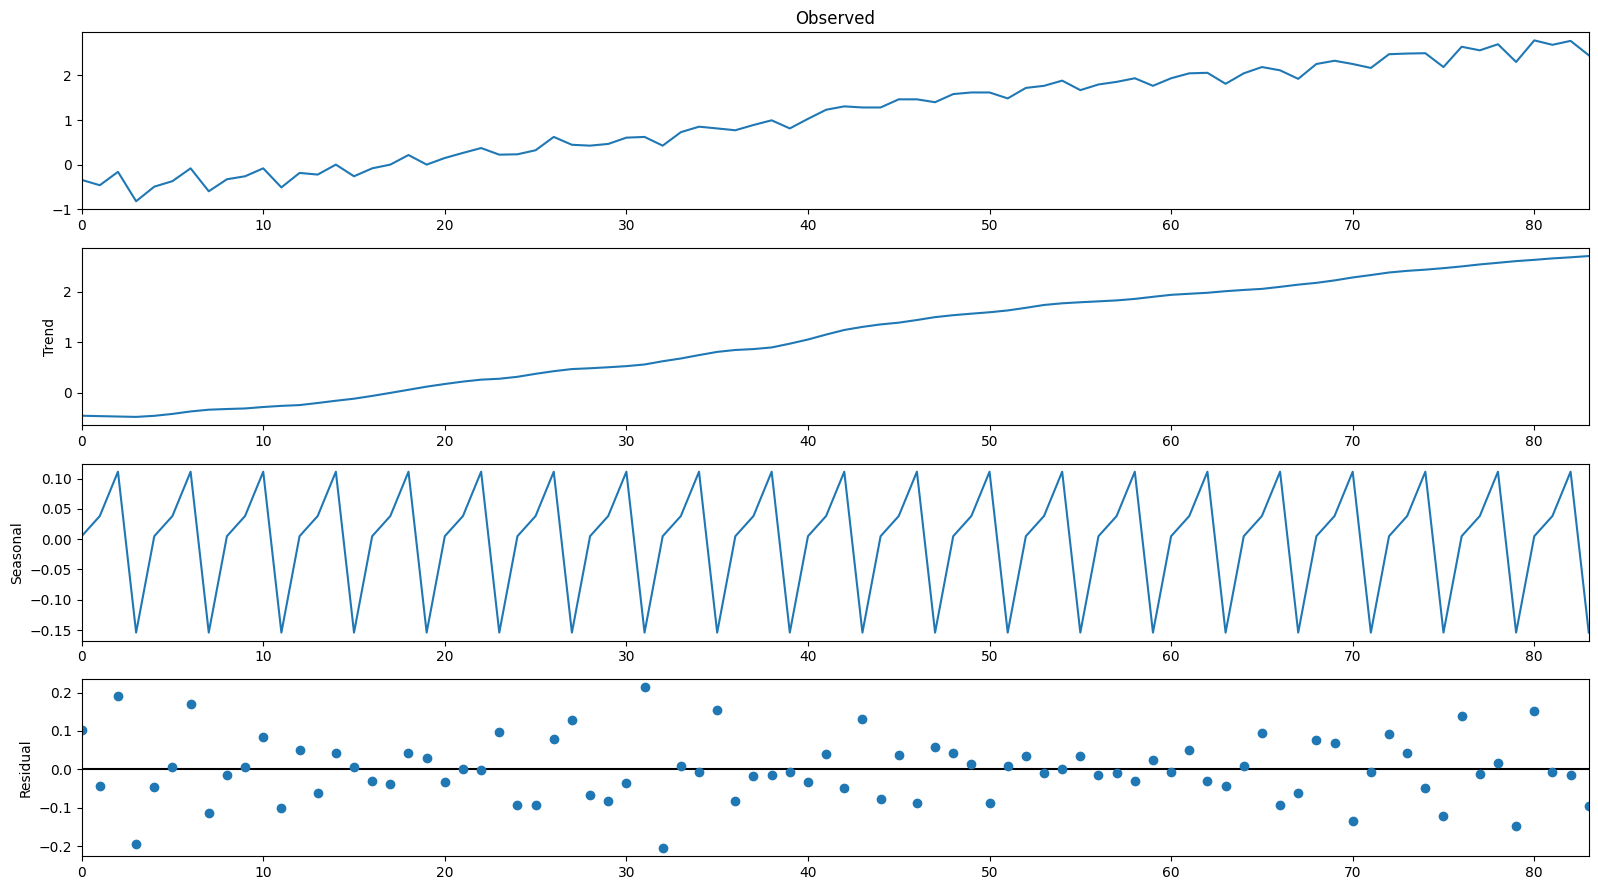

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

st_result = seasonal_decompose(
    data.log_value.values,
    model="additive",
    period=4,
    extrapolate_trend=True
)

fig = st_result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()

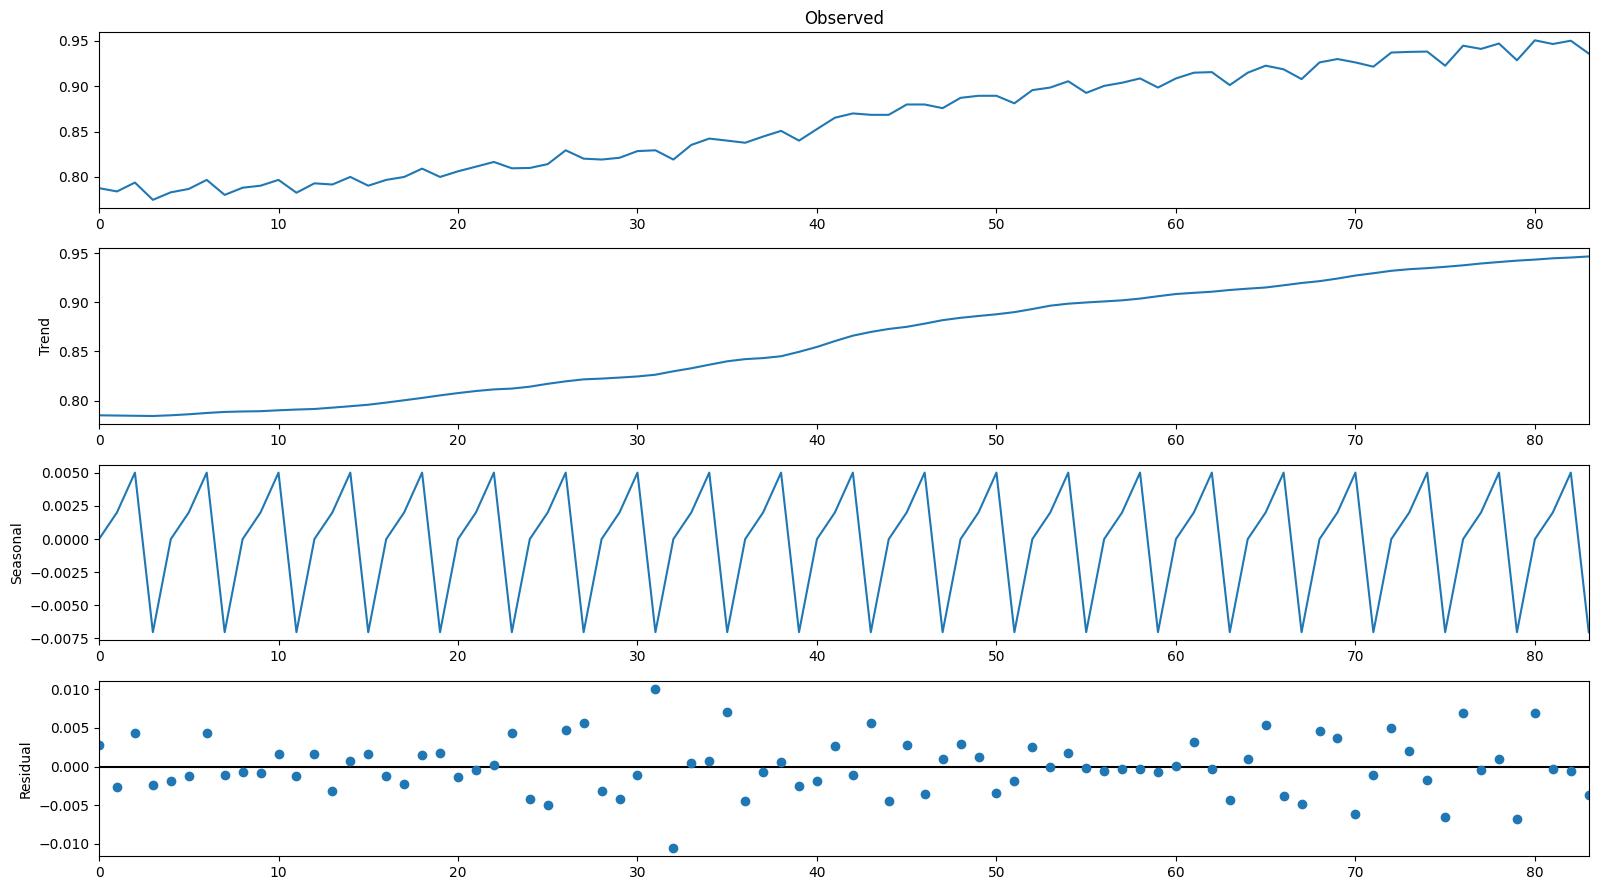

In [ ]:
st_result = seasonal_decompose(
    data.boxcox_value.values,
    model="additive",
    period=4,
    extrapolate_trend=True
)

fig = st_result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()

Que remarquez-vous (composante saisonnière et de tendance) ?

La saisonnalité semble bien être de période 4, la tendance obtenue est toujours croissante. Nous avons donc bien isolé les composantes de notre série. La transformation boxcox est plus pertinente car le résidu est plus faible.

## 13.7 Détermination d'un modèle SARIMA

Le modèle SARIMA possède 6 hyperparamètres : on le note SARIMA(p, d, q)(P, D, Q).


En première approche, nous allons effectuer les prévisions à l'aide de la transformée logarithmique.

Découpez votre dataset en deux parties : un train et un test (contenant 10% des points), prenez soin de ne pas randomiser votre dataset :

In [ ]:
train, test = train_test_split(data, test_size=.1, shuffle=False)

In [ ]:
len(train) / len(data)

0.8928571428571429

### 13.7.1 Identification des paramètres de stationnarisation des données

Le processus SARIMA que nous allons mettre en oeuvre nécessite de transformer les données sous forme stationnaire. Pour cela, on peut effectuer des différenciations.

In [ ]:
train['diff_log_value'] = train.log_value.diff()
train['seasonal_diff_log_value'] = train.diff_log_value.diff(4)

<AxesSubplot: >

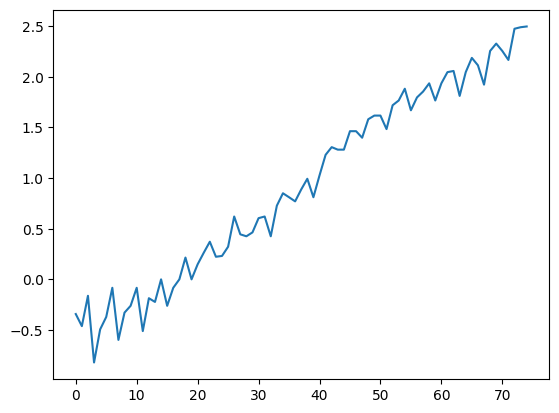

In [ ]:
train['log_value'].plot()

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

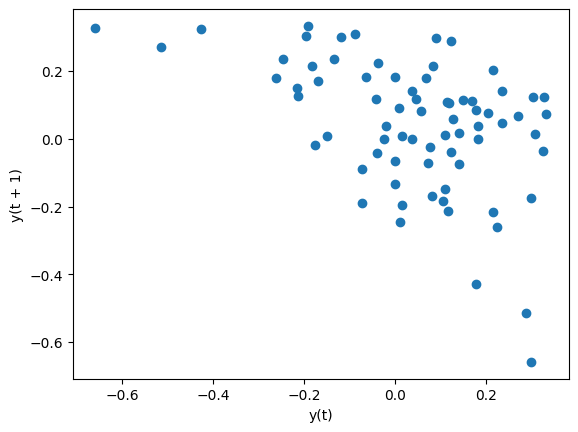

In [ ]:
from pandas.plotting import lag_plot
lag_plot(train.diff_log_value)

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

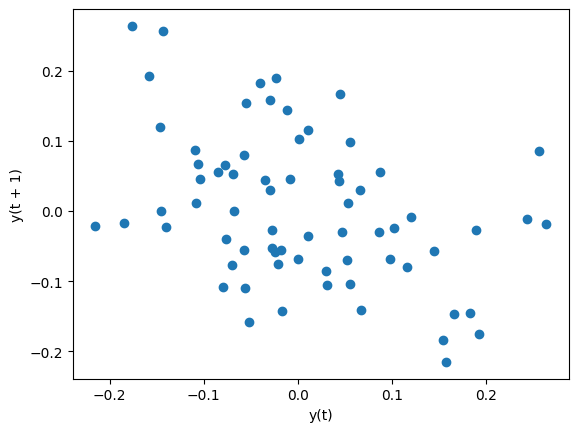

In [ ]:
lag_plot(train.seasonal_diff_log_value)

Ce diagramme vous semble-t-il représenter un processus stationnaire ?

Pour déterminer si c'est le cas, on peut effectuer un test de Dickey-Fuller :

In [ ]:
show_adfuller_stats(train, 'diff_log_value')

==== Augmented Dickey–Fuller test ================================================================================

---- diff_log_value ---------------------------------------------------

  statistical value: -0.15231631506294138
    (stationarity achieved if lower than the critical values)

  p-value: 0.6313597329925504
    (stationarity achieved if lower 0.05)

  lags considered for calculation: 16
  critical values: {'1%': -2.606080904893813, '5%': -1.9465793869098724, '10%': -1.6128587250058046}




In [ ]:
show_adfuller_stats(train, 'seasonal_diff_log_value')

==== Augmented Dickey–Fuller test ================================================================================

---- seasonal_diff_log_value ---------------------------------------------------

  statistical value: -2.747723333555503
    (stationarity achieved if lower than the critical values)

  p-value: 0.0058446493923942034
    (stationarity achieved if lower 0.05)

  lags considered for calculation: 16
  critical values: {'1%': -2.6092161124955497, '5%': -1.947056136273568, '10%': -1.6126044905526038}




Qu'en conclure ? que faut-il faire ? Corrigez la méthode de stationnarisation si nécessaire.

Il faut appliquer une différenciation saisonière avec une période = 4.

Quels sont les valeurs des hyperparamètres d et D d'un modèle SARIMA adaptées à ces données ?

d = 1 et D = 1 avec s = 4

### 13.7.2 Identification des paramètres SARIMA

Affichons l'ACF et le PACF pour notre série stationnarisée :

C:\Users\tboussaid\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


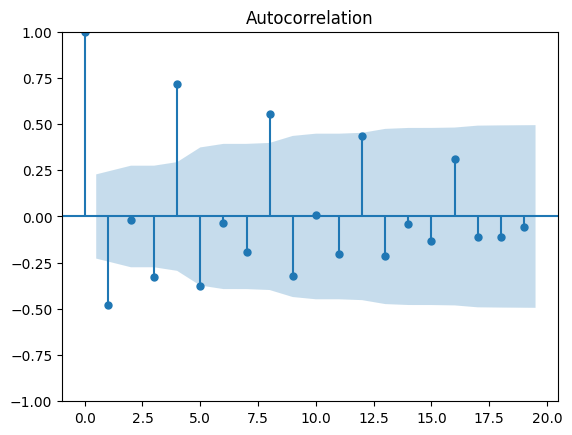

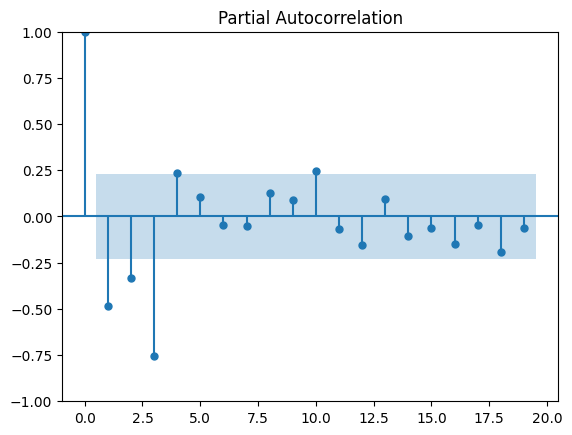

In [ ]:
plot_acf(train['diff_log_value'].dropna());
plot_pacf(train['diff_log_value'].dropna());

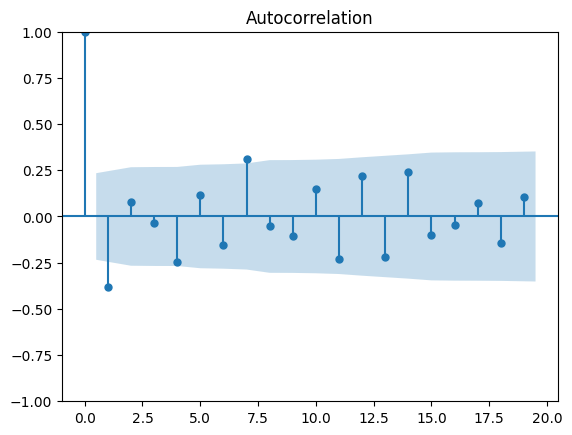

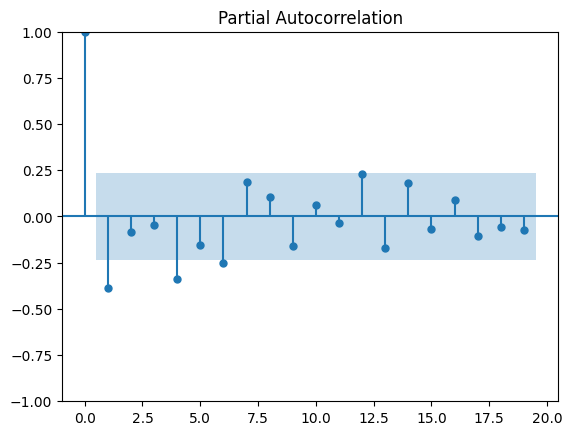

In [ ]:
plot_acf(train['seasonal_diff_log_value'].dropna());
plot_pacf(train['seasonal_diff_log_value'].dropna());

Identifiez sur la figure ci-dessus des candidats pour les valeurs des hyperparamètres p, q, P et Q :

In [ ]:
p_candidat = 1
q_candidat = 1
P_candidat = 1
Q_candidat = 0

En pratique, on va toujours tester un panel de jeux d'hyperparamètres et pas seulement les paramètres lus sur les autocorrélogrammes : c'est le Gridsearch.

Ainsi, on va définir pour chaque hyperparamètre une plage de variation, et on testera l'ensemble des combinaisons d'hyperparamètres résultant du croisement de ces plages.

Les valeurs lues nous servent de points centraux dans les plages de chaque hyperparamètre.

La méthode ci-dessous implémente le Gridsearch pour SARIMA :

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, endog, metric='AIC'):
    """
        Return dataframe with parameters, corresponding AIC and SSE

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """

    results = []

    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(endog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue

        if metric == 'BIC':
            bic = model.bic
            results.append([param, bic])

        else:
            aic = model.aic
            results.append([param, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', metric]
    #Sort in ascending order, lower metric is better
    result_df = result_df.sort_values(by=metric, ascending=True).reset_index(drop=True)

    return result_df

Définissez des palges de variation de chaque hyperparamètre. Ces plages doivent inclure les valeurs candidates trouvées ci-dessus :

In [ ]:
p = [0, 1, 2]
q = [0, 1, 2]
P = [0, 1, 2, 4*]
Q = [0, 1]

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))
parameters_list

72


[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 4, 0),
 (0, 0, 4, 1),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 1, 4, 0),
 (0, 1, 4, 1),
 (0, 2, 0, 0),
 (0, 2, 0, 1),
 (0, 2, 1, 0),
 (0, 2, 1, 1),
 (0, 2, 2, 0),
 (0, 2, 2, 1),
 (0, 2, 4, 0),
 (0, 2, 4, 1),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 1, 0),
 (1, 0, 1, 1),
 (1, 0, 2, 0),
 (1, 0, 2, 1),
 (1, 0, 4, 0),
 (1, 0, 4, 1),
 (1, 1, 0, 0),
 (1, 1, 0, 1),
 (1, 1, 1, 0),
 (1, 1, 1, 1),
 (1, 1, 2, 0),
 (1, 1, 2, 1),
 (1, 1, 4, 0),
 (1, 1, 4, 1),
 (1, 2, 0, 0),
 (1, 2, 0, 1),
 (1, 2, 1, 0),
 (1, 2, 1, 1),
 (1, 2, 2, 0),
 (1, 2, 2, 1),
 (1, 2, 4, 0),
 (1, 2, 4, 1),
 (2, 0, 0, 0),
 (2, 0, 0, 1),
 (2, 0, 1, 0),
 (2, 0, 1, 1),
 (2, 0, 2, 0),
 (2, 0, 2, 1),
 (2, 0, 4, 0),
 (2, 0, 4, 1),
 (2, 1, 0, 0),
 (2, 1, 0, 1),
 (2, 1, 1, 0),
 (2, 1, 1, 1),
 (2, 1, 2, 0),
 (2, 1, 2, 1),
 (2, 1, 4, 0),
 (2, 1, 4, 1),
 (2, 2, 0, 0),
 (2, 2, 0, 1),
 (2, 2, 1,

Recherchons les meilleurs hyperparamètres à l'aide de l'AIC :

In [ ]:
warnings.filterwarnings('ignore')

result_df = optimize_SARIMA(parameters_list,
                            d=1,
                            D=1,
                            s=4, endog=train['log_value'],
                            metric='AIC')
result_df

  0%|          | 0/72 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(0, 1, 1, 0)",-130.648544
1,"(0, 1, 2, 1)",-130.356630
2,"(0, 1, 0, 1)",-130.287455
3,"(0, 1, 2, 0)",-128.967404
4,"(0, 1, 1, 1)",-128.845879
...,...,...
67,"(0, 0, 2, 0)",-112.118187
68,"(0, 0, 4, 0)",-111.345499
69,"(0, 0, 1, 1)",-111.330145
70,"(0, 0, 0, 0)",-110.195579


Comparez le jeu d'hyperparamètres optimal obtenu avec pour mesure de qualité l'AIC et le BIC.

L'AIC le plus faible est trouvé pour (p, q, P, Q) = (0, 1, 1, 0), c'est donc cette valeur que nous retenons.

### 13.7.3 Entrainement de SARIMA et analyse des résidus

Le Gridsearch sur les jeux d'hyperparamètres testés fournit un jeu optimal. On analyse ci-dessous le résultat du processus SARIMA sur les données d'entraînement :

In [ ]:
best_model = SARIMAX(train['log_value'], order=(0, 1, 1), seasonal_order=(1, 1, 0, 4)).fit()
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          log_value   No. Observations:                   75
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 4)   Log Likelihood                  68.324
Date:                            Wed, 22 Nov 2023   AIC                           -130.649
Time:                                    11:22:13   BIC                           -123.903
Sample:                                         0   HQIC                          -127.969
                                             - 75                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6362      0.108     -5.868      0.000      -0.849      -0.424
ar.S.L4       -0.3489      0.120   

Ci-dessous, on affiche une analyse des résidus :

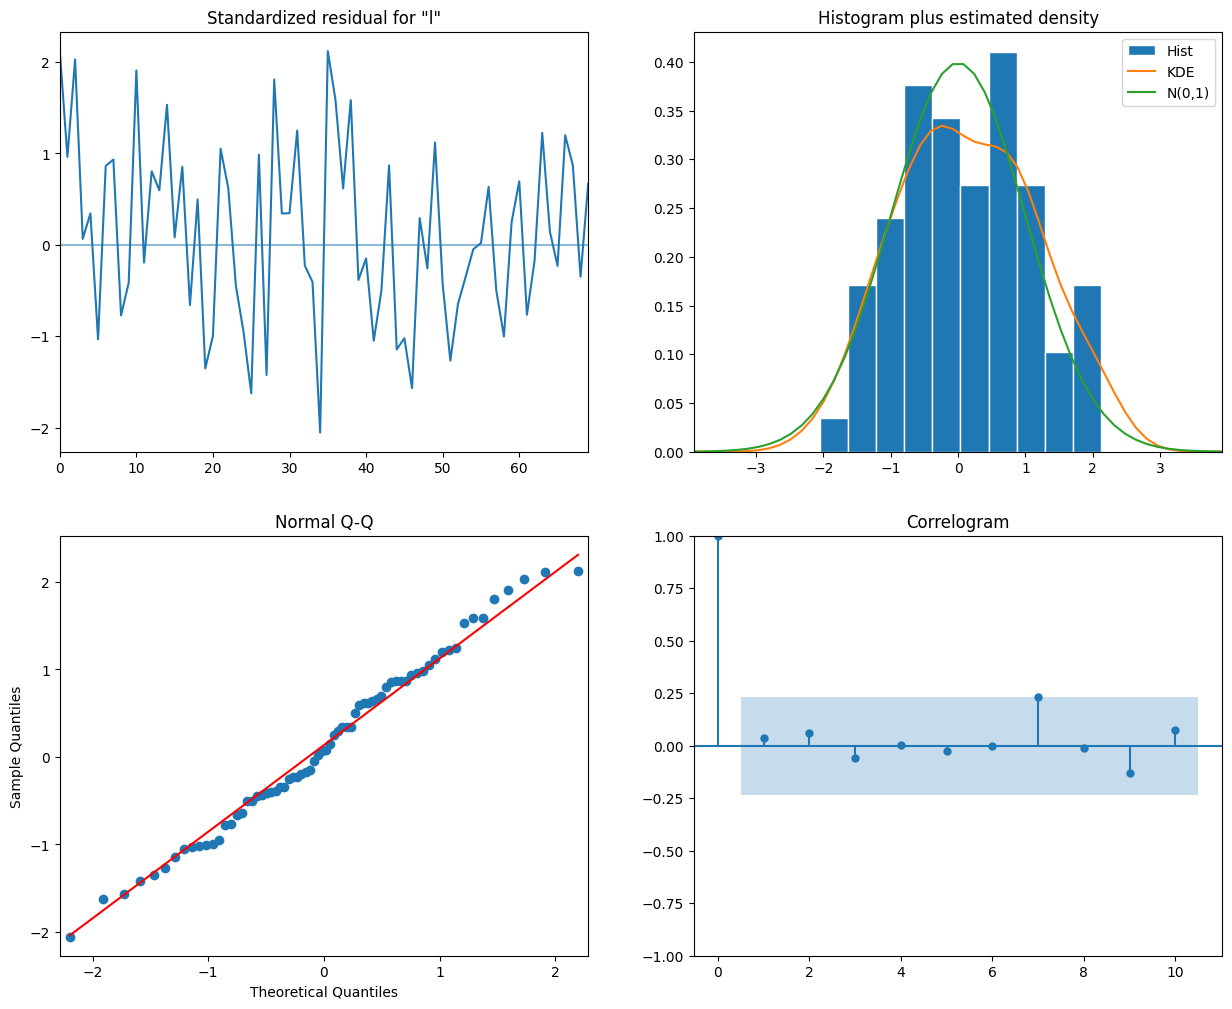

In [ ]:
best_model.plot_diagnostics(figsize=(15,12));

Effectuez l'analyse : les résidus s'apparentent-ils à un bruit blanc gaussien ?

Oui, car le diagnostique laisse penser que nous avons un bruit guaussien (correlogramme sans valeur significative, normal Q-Q aligné sur une droite, kde proche d'une gaussienne). De plus le test statistique de `Ljung-Box` a une p-value supérieure à 0.05.

### 13.7.4 Prédiction sur le jeu de test

Nous pouvons finalement prédire les valeurs de notre dataset de test et calculer des métriques de performance :

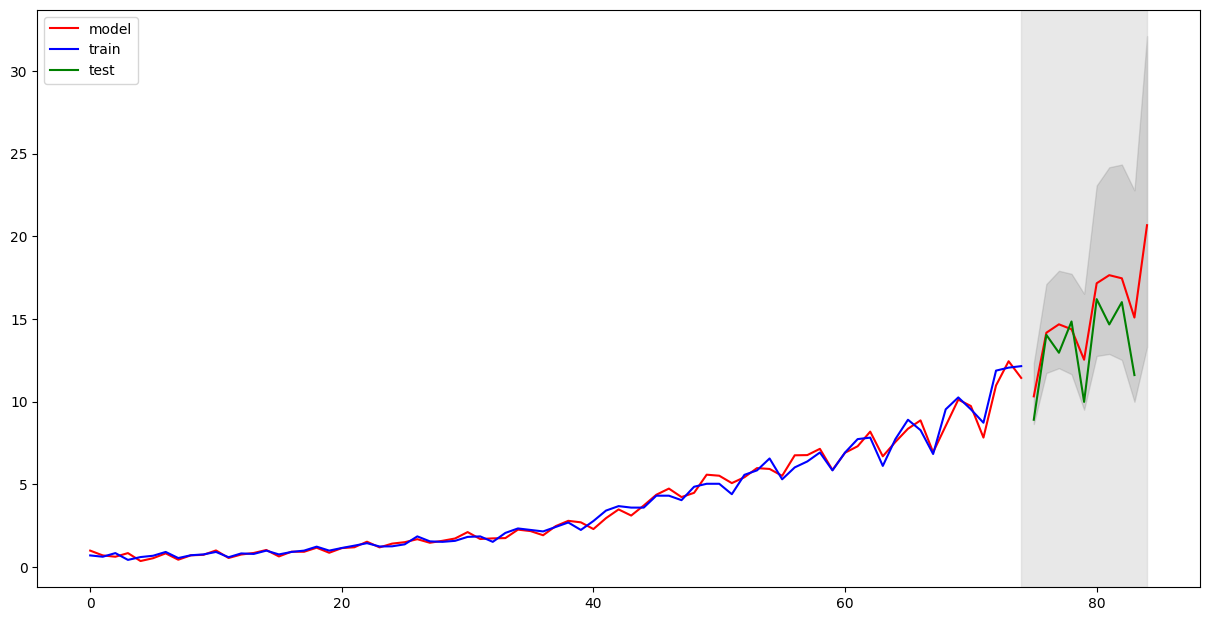

In [ ]:
data['arima_model'] = best_model.fittedvalues
forecast = best_model.predict(start=train.shape[0], end=train.shape[0] + len(test))
forecast = np.exp(data['arima_model'].append(forecast))

pred_ci = best_model.get_prediction(start=train.shape[0], end=train.shape[0] + test.shape[0]).conf_int(alpha=.05)
future = ([np.nan] * len(train)) + test.value.to_list()

plt.figure(figsize=(15, 7.5))
plt.fill_between(pred_ci.index,
                 np.exp(pred_ci['lower log_value']),
                 np.exp(pred_ci['upper log_value']), color='k', alpha=.2)
plt.plot(forecast, color='r', label='model')
plt.axvspan(train.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')x
plt.plot(train['value'], label='train', color='blue')
plt.plot(future, label='test', color='green')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

forecasts_only = np.exp(best_model.predict(start=train.shape[0], end=train.shape[0] + len(test) - 1))

mae = mean_absolute_error(test.value, forecasts_only)
mse = mean_squared_error(test.value, forecasts_only)

print("""
MAE : {}
MSE : {}
""".format(mae, mse))


MAE : 1.6820167090728664
MSE : 3.9611823005583853



## 13.8 Variante (Bonus)

Testez SARIMA avec la transformée BoxCox.